## Step by step 
- 1 . Checking device , GPU support CUDA ? CPU .
- 2 . Preparing dataset (MNIST).
- 3 . Define model .
- 4 . Creating Entropy loss function .
- 5 . Training model .
- 6 . Testing .
- 7 . Saving parameters .
- 8 . Prediction .


In [47]:
# 1. Checking device 
import torch

# Check GPU , CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

Device : cuda


### 2. Loading database from Pytorch library 
* CIFAR_10 

In [48]:
# import libraries pytorch , numpy , pandas ....

# basic libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import torch

# more 
import torchvision 
import torchvision.transforms as transforms 
import torch.functional as F 
import torch.nn as nn 

In [49]:
# set up mean and standard 

mean = [0.4914, 0.4822, 0.4465]
std =  [0.2470, 0.2435, 0.2616]

In [50]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean), (std))  # MNIST mean and std
])

# Download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)

# Download and load test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                        shuffle=False, num_workers=2)

In [51]:
# Access the raw PIL image (index 0) without transforms
raw_image = trainset.data[0]

# Print the shape
print(raw_image.shape) 

(32, 32, 3)


In [52]:
print(f"length of trainloader : {len(trainloader)}")

print(f"length of trainset {len(trainset)}")

print(trainset)

class_names = trainset.classes
print("Class names:", class_names)  # Output: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



length of trainloader : 782
length of trainset 50000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
           )
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# define model 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            # Layer 1st 
            nn.Conv2d(3 , 32 , 3), # 3 channels , 10 filters , kernel size 3 (30 , 30 , 32)
            nn.ReLU(),

            # Layer 2nd
            nn.Conv2d(32, 64 , 3), # 10 channels , 10 filters , kernel size 3 (28 , 28 , 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # kernel size 2 , stride 2   -> (14 , 14 , 64)

            # Layer 3rd
            nn.Conv2d(64, 128 , 3), # 10 channels , 10 filters , kernel size 3 (12 , 12 , 128)
            nn.ReLU(),

            # Layer 4th
            nn.Conv2d(128 , 64 , 3), # 10 channels , 10 filters , kernel size 3 (10 , 10 , 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # kernel size 2 , stride 2 (10 , 10 , 10) -> (5 , 5 , 64)

            nn.Flatten(), # flatten the image  -> (5*5*64) = 1600
            nn.Linear(5*5*64 , 10), # 250 input features , 10 output features (10 classes)
            # nn.Linear(128 , 10), # 250 input features , 10 output features (10 classes)

        )
    def forward(self, x):
        x = self.model(x)
        return x
    
# create model
model = CNN().to(device)
print(model)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5, inplace=False)
    (13): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Dropout(p=0.5, inplace=False)
   

### 4. Creating Entropy Loss function

In [60]:
import torch.optim as optim
# init parameters 
learning_rate = 0.001 
# using entropy loss function 
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam với learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate  , weight_decay= 1e-4)


In [61]:
num_epochs = 10
accuracy_train = np.zeros(num_epochs) # create array to store accuracy
accuracy_test = np.zeros(num_epochs) # create array to store accuracy
loss_train = np.zeros(num_epochs) # create array to store loss
loss_test = np.zeros(num_epochs) # create array to store loss


# Training the model

for epoch in range(num_epochs):     # 5 times 
    model.train()   # training mode for model 
    running_loss = 0.0
    correct = 0 
    total = 0

    # batch 
    for i , (images , labels) in enumerate(trainloader): # enumerate to get index and data:
        images , labels = images.to(device) , labels.to(device)     # convert image and label to device 

        # Forward pass 
        outputs = model(images)

        # Calculate loss value 
        loss = criterion(outputs , labels)

        # Backward pass 
        optimizer.zero_grad()   # setup zero to re compute 
        loss.backward()         # compute gradient 
        optimizer.step()        # update parameters 

        running_loss += loss.item()

        # Counting true value 
        _, predicted = torch.max(outputs , 1)
        total += labels.size(0)
        correct += (predicted == labels ).sum().item()
            
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%')
        accuracy_train[epoch] = accuracy
        loss_train[epoch] = running_loss/len(trainloader)
        #accuracy_test[epoch] = test(model , testloader)
    
    # Test the model 
    model.eval()  # evaluation mode for model
    correct = 0 
    total = 0

    with torch.no_grad():  
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)   # lo    ad to device 

            # predict
            outputs = model(images)
            loss = criterion(outputs, labels)  # calculate loss value
            loss_test[epoch] = loss.item()
            # print(f"Loss value of test set data : {loss(outputs , labels).item()}")
            
            # get highest value 
            _, predicted = torch.max(outputs, 1)

            """
            explain torch.max
            outputs = torch.tensor([
        [0.1, 0.3, 0.6, 0.0],  # Ảnh 1: xác suất lớp 2 cao nhất (0.6)
        [0.7, 0.2, 0.1, 0.0],  # Ảnh 2: xác suất lớp 0 cao nhất (0.7)
        [0.1, 0.8, 0.05, 0.05] # Ảnh 3: xác suất lớp 1 cao nhất (0.8)
    ])
            """
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calculate accuracy
    accuracy = 100 * correct / total
    accuracy_test[epoch] = accuracy
    # print(f'Test Accuracy: {accuracy:.2f}%')


print('Training Finished!')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 64x10)

### 6.Testing

In [ ]:

model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)   # lo    ad to device 

        # predict
        outputs = model(images)
        # print(f"Loss value of test set data : {loss(outputs , labels).item()}")
        
        # get highest value 
        _, predicted = torch.max(outputs, 1)

        """
        explain torch.max
        outputs = torch.tensor([
    [0.1, 0.3, 0.6, 0.0],  # Ảnh 1: xác suất lớp 2 cao nhất (0.6)
    [0.7, 0.2, 0.1, 0.0],  # Ảnh 2: xác suất lớp 0 cao nhất (0.7)
    [0.1, 0.8, 0.05, 0.05] # Ảnh 3: xác suất lớp 1 cao nhất (0.8)
])
        """
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calculate accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# 6.9s

Test Accuracy: 73.57%


In [ ]:
# Lưu mô hình đã huấn luyện vào một file
PATH = './simple_cnn.pth'
torch.save(model.state_dict(), PATH)
print("Save Done!")


Save Done!


In [ ]:
print(accuracy_train)
print(accuracy_test)

[49.258 65.47  71.552 75.15  77.702]
[59.13 68.32 72.54 74.14 73.57]


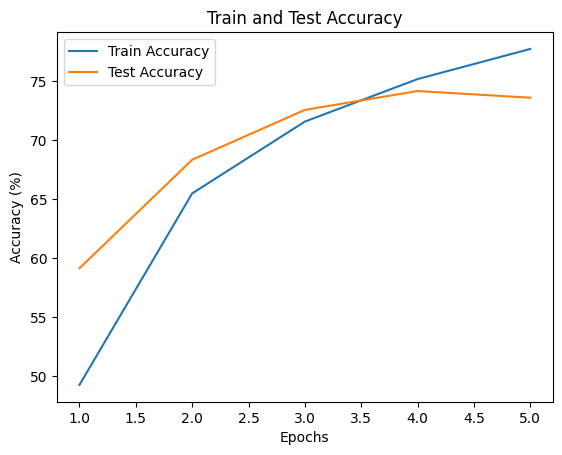

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plotting the accuracy
plt.plot(range(1, num_epochs + 1), accuracy_train, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), accuracy_test, label='Test Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()  

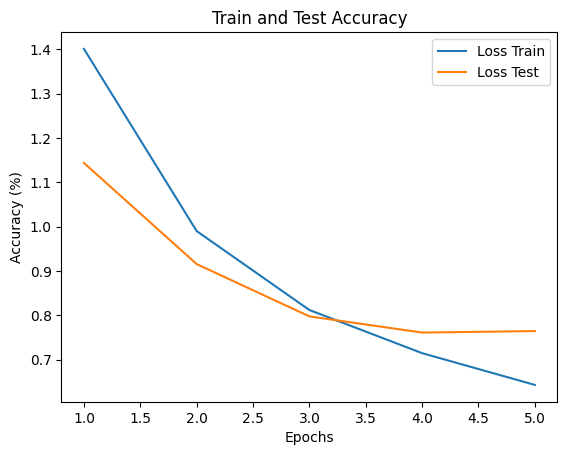

In [ ]:


# Plotting the accuracy
plt.plot(range(1, num_epochs + 1), loss_train, label='Loss Train')
plt.plot(range(1, num_epochs + 1), loss_test, label='Loss Test')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()  
plt.show()
